In [1]:
from qonstruct.code_builder.base import *
from qonstruct.code_builder.color_code import *

import networkx as nx

import docplex.mp
from docplex.mp.model import Model

In [2]:
import qonstruct.io

In [59]:
def remove_stray_nodes(gr: nx.Graph) -> nx.Graph:
    _gr = gr.copy()
    removed = set()
    for x in gr.nodes():
        if gr.degree(x) == 0:
            removed.add(x)
    for x in removed:
        _gr.remove_node(x)
    return _gr


def read_in_color_code(code: str, semi=False) -> nx.Graph:
    _gr = qonstruct.io.read_tanner_graph_file(code)
    color_tanner_graph(_gr)
    if semi:
        _gr = make_semihyperbolic(_gr, '7_1_3')
    gr = remove_stray_nodes(_gr)
    removed = set()
    for x in gr.nodes():
        if gr.nodes[x]['node_type'] == 'z':
            removed.add(x)
    for x in removed:
        gr.remove_node(x)
    return gr

def remove_color_from_graph(gr: nx.Graph, c: int, leave=None) -> nx.Graph:
    _gr = gr.copy()
    removed = set()
    for x in gr.nodes():
        if 'color' in gr.nodes[x] and gr.nodes[x]['color'] == c\
        and not (leave is not None and x in leave):
            removed.add(x)
    for x in removed:
        _gr.remove_node(x)
    return _gr

def get_bfs_tree(gr: nx.Graph) -> nx.Graph:
    _gr = nx.bfs_tree(gr, 0)
    for x in gr.nodes():
        if 'color' in gr.nodes[x]:
            _gr.nodes[x]['color'] = gr.nodes[x]['color']
    return _gr.to_undirected()

def to_check_graph(gr: nx.Graph) -> nx.Graph:
    _gr = nx.Graph()
    for x in gr.nodes():
        if gr.nodes[x]['node_type'] != 'x':
            continue
        _gr.add_node(x, color=gr.nodes[x]['color'])
    for x in _gr.nodes():
        for y in _gr.nodes():
            if x >= y:
                continue
            if len(list(nx.common_neighbors(gr, x, y))) > 0:
                _gr.add_edge(x,y)
    return _gr

def draw_graph(gr: nx.Graph, as_check_graph=False):
    if as_check_graph:
        gr = to_check_graph(gr)
    #else:
        #gr = remove_stray_nodes(gr)
    COLOR_ARRAY = ['red', 'green', 'blue']
    SIZE = 200 if as_check_graph else 100
    sizes = [ SIZE if 'color' in gr.nodes[x] else 10 for x in gr.nodes() ]
    colors = [ COLOR_ARRAY[gr.nodes[x]['color']] if 'color' in gr.nodes[x] else 'k' for x in gr.nodes() ]
    if as_check_graph:
        nx.draw(gr, node_size=sizes, node_color=colors, with_labels=as_check_graph)
    else:
        nx.draw_kamada_kawai(gr, node_size=sizes, node_color=colors, with_labels=as_check_graph)

In [60]:
#gr = read_in_color_code('codes/hycc/3_4_4/96_20_4_4.2.txt')
#gr = read_in_color_code('codes/hycc/3_4_4/96_20_6_6.2.txt')
gr = read_in_color_code('codes/hycc/3_4_4/24_8_4_4.0.txt')
#gr = read_in_color_code('codes/hycc/4_4_4/32_12_4_4.0.txt')
#gr = read_in_color_code('codes/hycc/6_6_6/72_40_4_4.0.txt')
#gr = read_in_color_code('codes/hycc/4_4_4/128_36_8_8.4.txt')

computed 3-coloring


In [69]:
_gr = gr
gRG = remove_color_from_graph(_gr, 2, leave=[24])
gRB = remove_color_from_graph(_gr, 1)
gGB = remove_color_from_graph(_gr, 0)
print(nx.is_planar(gRG), nx.is_planar(gRB), nx.is_planar(gGB))

# Print original checks and widowed qubits for each.
print('Original checks:')
for ch in gr.graph['checks']['x']:
    supp = list(gr.neighbors(ch))
    print('\t', ch, ':', ' '.join([str(x) for x in supp]), '\tcolor =', gr.nodes[ch]['color'])
print('Widowed Qubits:')
for (gg, colors) in [(gRG, 'RG'), (gRB, 'RB'), (gGB, 'GB')]:
    widowed = [x for x in gg.nodes() if gg.degree(x) == 0]
    print('\t', colors, ':', ' '.join([str(x) for x in widowed]))


True True True
Original checks:
	 24 : 0 4 8 12 16 20 	color = 2
	 25 : 3 5 10 15 17 22 	color = 2
	 26 : 1 6 11 14 19 21 	color = 2
	 27 : 2 7 9 13 18 23 	color = 2
	 28 : 0 12 3 15 1 14 2 13 	color = 0
	 29 : 8 16 10 17 11 19 9 18 	color = 0
	 30 : 0 16 3 17 1 19 2 18 	color = 1
	 31 : 8 20 10 22 11 21 9 23 	color = 1
Widowed Qubits:
	 RG : 5 6 7
	 RB : 
	 GB : 


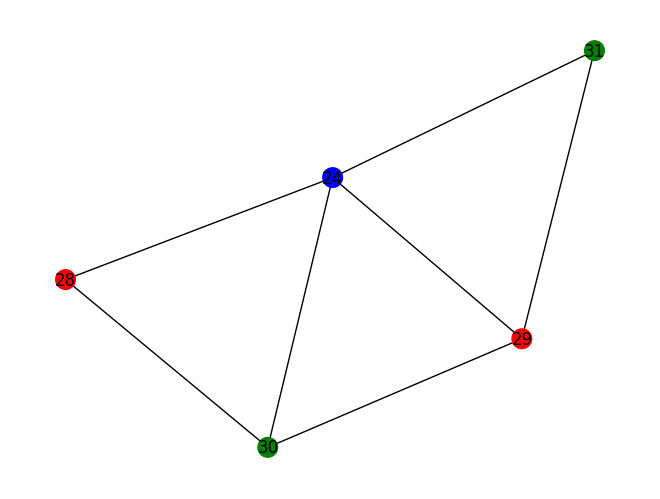

In [70]:
draw_graph(gRG, as_check_graph=True)

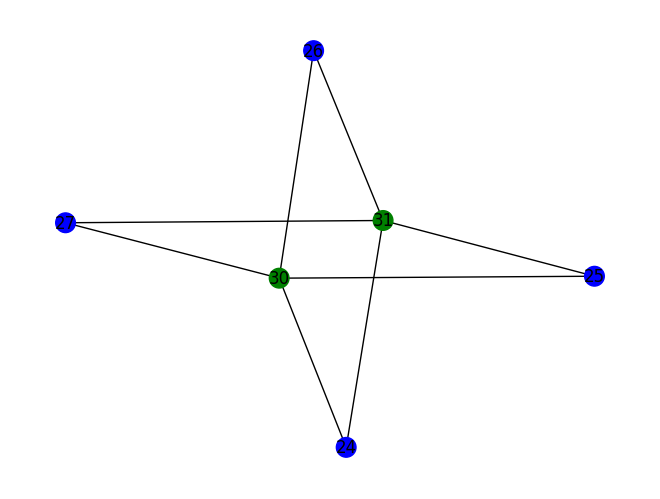

In [52]:
draw_graph(gGB, as_check_graph=True)

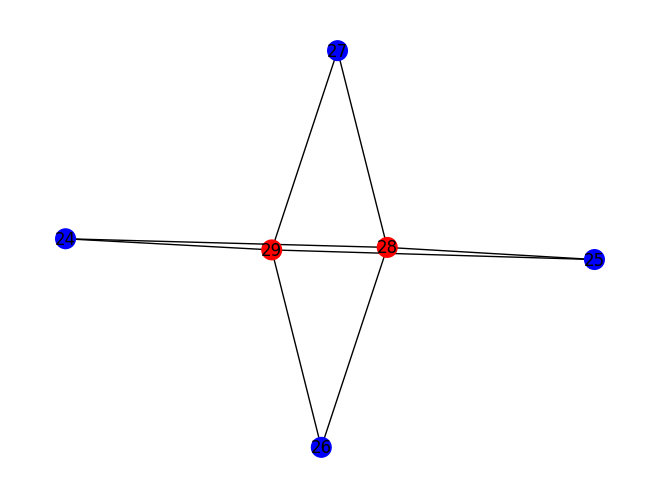

In [53]:
draw_graph(gRB, as_check_graph=True)

set()
False


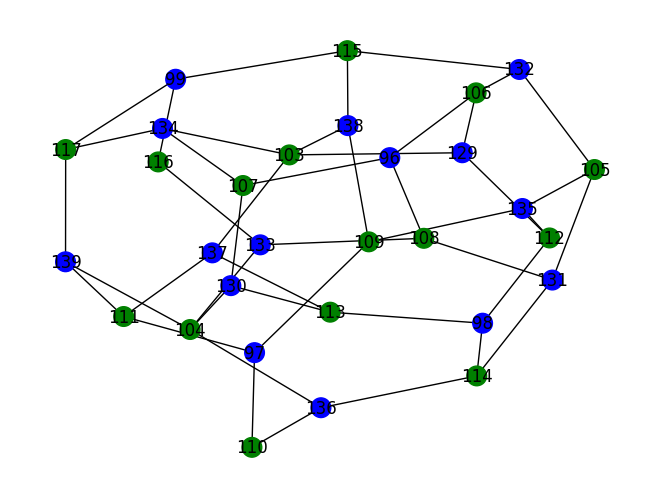

In [392]:
# Merge nodes with identical neighbors in the check graph
gGB = remove_color_from_graph(_gr, 0)

tot_removed = set()
while True:
    _gGB = to_check_graph(gGB)
    removed = set()
    for x in _gGB.nodes():
        if x in removed:
            continue
        for y in _gGB.nodes():
            if x >= y or y in removed:
                continue
            ncomm = len(list(nx.common_neighbors(_gGB, x, y)))
            if ncomm == _gGB.degree(x) and ncomm == _gGB.degree(y):
                removed.add(y)
    for y in removed:
        gGB.remove_node(y)
    tot_removed |= removed
    if len(removed) == 0 or nx.is_planar(gGB):
        break
draw_graph(gGB, as_check_graph=True)
print(tot_removed)
print(nx.is_planar(gGB))

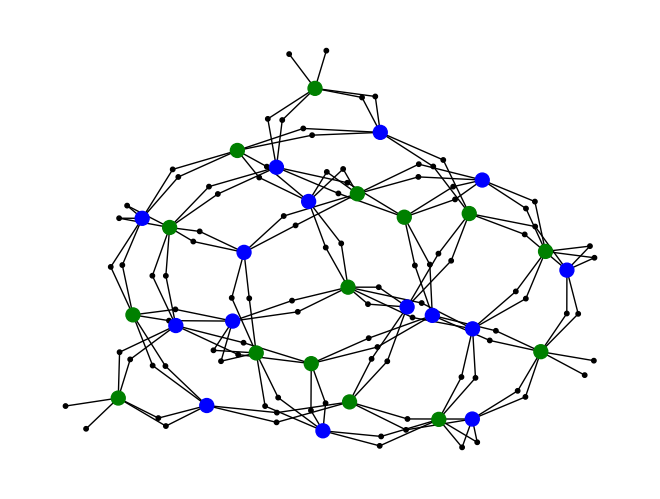

In [393]:
draw_graph(gGB)

In [344]:
# Plots of code capacity LER.
data_file = 'qontra/Release/c2cap.csv'
# Read data file
with open(data_file, 'r') as reader:
    lines = reader.readlines()
data = {}
for line in lines:
    if ',' not in line:
        continue
    ldat = line.split(',')
    code = ldat[0].split('.')[0]
    if code not in data:
        data[code] = {}
    p, bernorm = float(ldat[1]), float(ldat[3])
    data[code][p] = bernorm

{'96_20_6_6': {0.008: 0.00065918, 0.009: 0.000823975, 0.01: 0.0010376, 0.02: 0.00459595, 0.03: 0.0110229}, '384_20_12_12': {0.008: 5.5689e-07, 0.009: 9.47751e-07, 0.01: 1.74386e-06, 0.02: 0.000143433, 0.03: 0.00109253}, '864_20_16_16': {0.02: 3.05176e-06, 0.03: 8.54492e-05, 0.04: 0.0010376, 0.05: 0.00543213}, '1536_20_24_24': {0.03: 8.23975e-06, 0.04: 0.000164795, 0.05: 0.00144043}, '48_12_4_4': {0.008: 0.00154622, 0.009: 0.0022583, 0.01: 0.00252279, 0.02: 0.00892131, 0.03: 0.0177205, 0.04: 0.0273234, 0.05: 0.0366618}, '192_12_8_8': {0.008: 8.5318e-06, 0.009: 1.65304e-05, 0.01: 3.43323e-05, 0.02: 0.000590007, 0.03: 0.00286865, 0.04: 0.0086263, 0.05: 0.0191854}, '432_12_12_12': {0.01: 5.29819e-07, 0.02: 3.27781e-05, 0.03: 0.000467936, 0.04: 0.00306193, 0.05: 0.0100301}, '768_12_16_16': {0.02: 2.21142e-06, 0.03: 7.88371e-05, 0.04: 0.000681559, 0.05: 0.00393677}, '72_40_4_4': {0.008: 0.00210571, 0.009: 0.00253906, 0.01: 0.00305786, 0.02: 0.00880432, 0.03: 0.0139191}, '288_40_8_8': {0.008:

In [357]:
c1 = '#7D0A0A'
c2 = '#BF3131'
c3 = '#EAD196'
c4 = '#F3EDC8'
c5 = '#004225'
c6 = '#F5F5DC'
c7 = '#FFB000'
c8 = '#FFCF9D'

import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42

def plot_cc_ber(codes: list[str]):
    colors = [c1, c2, c3, c5]
    markers = ['-o', '--x', '-.D', ':^', '--.*']

    fig, ax = plt.subplots()
    fig.set_size_inches(6.0, 3.2)
    
    for (i,c) in enumerate(codes):
        x,y = [], []
        for (a,b) in data[c].items():
            x.append(a)
            y.append(b)
        ax.plot(x,y, markers[i], color=colors[i], ms=10, label=c)
    ax.set_xlabel('Physical Error Rate', fontsize=12)
    ax.set_ylabel('Norm. Block Error Rate', fontsize=12)
    ax.legend(fontsize=10)
    ax.set_yscale('log')
    plt.show()


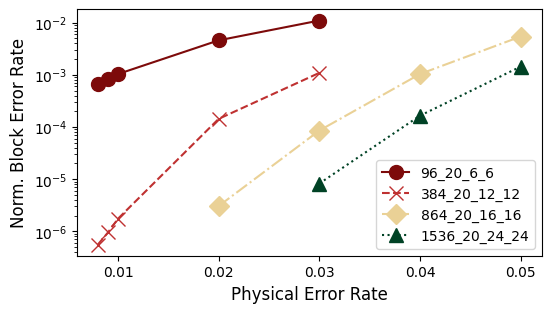

In [352]:
plot_cc_ber(['96_20_6_6', '384_20_12_12', '864_20_16_16', '1536_20_24_24'])

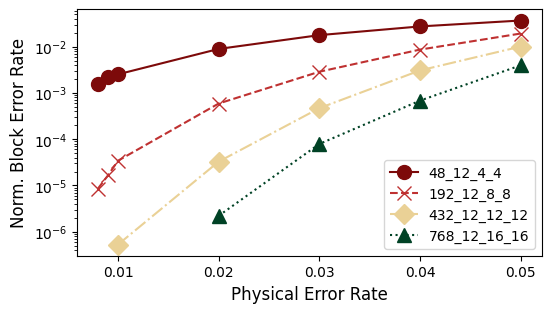

In [354]:
plot_cc_ber(['48_12_4_4', '192_12_8_8', '432_12_12_12', '768_12_16_16'])

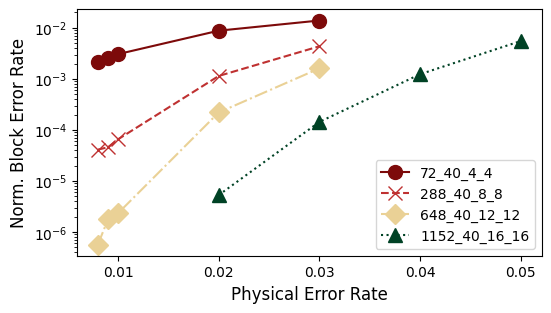

In [355]:
plot_cc_ber(['72_40_4_4', '288_40_8_8', '648_40_12_12', '1152_40_16_16'])

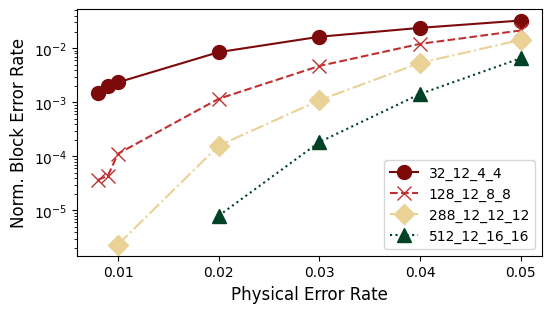

In [356]:
plot_cc_ber(['32_12_4_4', '128_12_8_8', '288_12_12_12', '512_12_16_16'])